In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 数据集描述
蘑菇数据集，包括毒性，大小，表面，颜色等，所有数据均为字符串类型，分析毒性与其他属性的关系
# 读取数据集

In [2]:
dataset = pd.read_csv("./mushrooms.csv")
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
class                       8124 non-null object
cap-shape                   8124 non-null object
cap-surface                 8124 non-null object
cap-color                   8124 non-null object
bruises                     8124 non-null object
odor                        8124 non-null object
gill-attachment             8124 non-null object
gill-spacing                8124 non-null object
gill-size                   8124 non-null object
gill-color                  8124 non-null object
stalk-shape                 8124 non-null object
stalk-root                  8124 non-null object
stalk-surface-above-ring    8124 non-null object
stalk-surface-below-ring    8124 non-null object
stalk-color-above-ring      8124 non-null object
stalk-color-below-ring      8124 non-null object
veil-type                   8124 non-null object
veil-color                  8124 non-null object
ring-number

可以发现，一共包括23个属性，没有缺失值
# 直观分析——颜色鲜艳的蘑菇都有毒？

In [3]:
poison = dataset[dataset["class"] == "p"]["cap-color"]
not_poison = dataset[dataset["class"] != "p"]["cap-color"]
# print(pd.value_counts(not_poison))
poison_color = pd.concat([pd.value_counts(poison),pd.value_counts(not_poison),pd.value_counts(dataset["cap-color"])],axis=1,keys=["poison","normal","all"])
poison_color = poison_color.fillna(value=0)
# print(poison_color)
poison_color = poison_color.groupby(poison_color.columns,axis=1).apply(lambda x:x / x.sum())
print(poison_color.sort_values(by="poison").loc[["p","b","y","e"]])

     poison    normal       all
p  0.022472  0.013308  0.017725
b  0.030644  0.011407  0.020679
y  0.171604  0.095057  0.131955
e  0.223698  0.148289  0.184638


可得还是有一定道理的，尤其是黄色和红色的蘑菇

# 相关性分析——判断各指标与毒性相关性
计算各不同指标下有毒的概率判断单独指标与毒性之间的关系

In [4]:
def analysis_poison(data,index_name):
    data["class"].replace({"p":1,"e":0},inplace=True)
    return data.groupby([index_name])["class"].sum() / pd.value_counts(data[index_name])
#     pd.value_counts(a)
# analysis_poison(dataset[["class","cap-color"]],"cap-color")   

c:\users\qiank\appdata\local\programs\python\python35\lib\site-packages\pandas\core\generic.py:3924: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


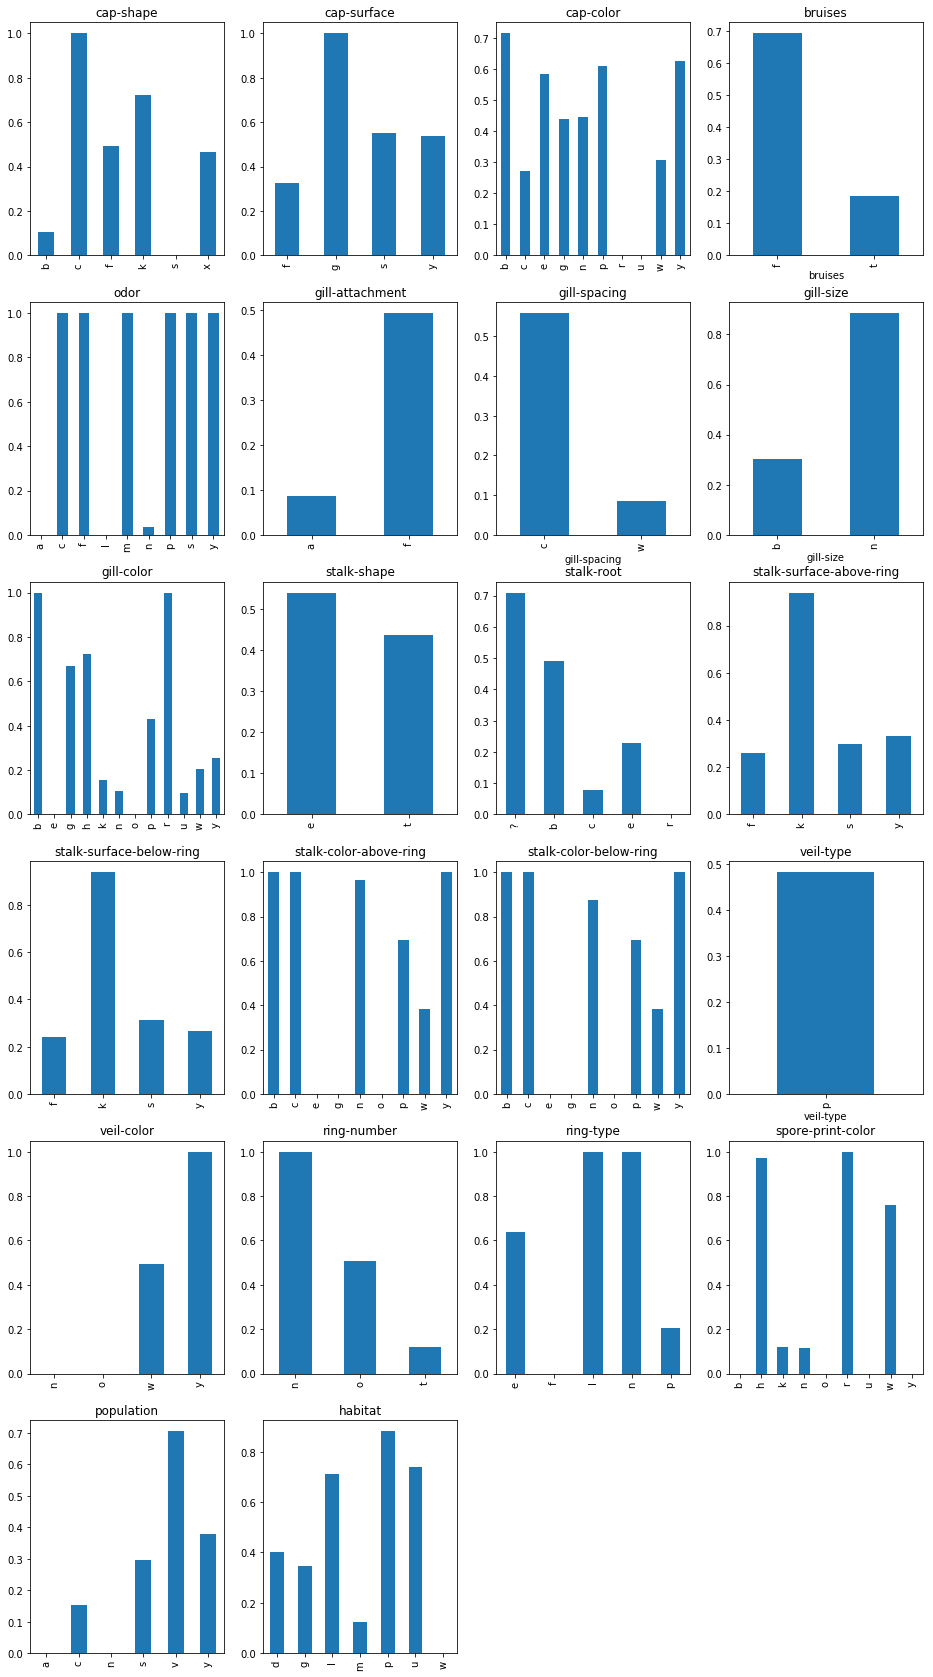

cap-shape:c                   1.000000
cap-surface:g                 1.000000
odor:c                        1.000000
odor:f                        1.000000
odor:m                        1.000000
odor:p                        1.000000
odor:s                        1.000000
odor:y                        1.000000
gill-size:n                   0.885350
gill-color:b                  1.000000
gill-color:r                  1.000000
stalk-surface-above-ring:k    0.939292
stalk-surface-below-ring:k    0.937500
stalk-color-above-ring:b      1.000000
stalk-color-above-ring:c      1.000000
stalk-color-above-ring:n      0.964286
stalk-color-above-ring:y      1.000000
stalk-color-below-ring:b      1.000000
stalk-color-below-ring:c      1.000000
stalk-color-below-ring:n      0.875000
stalk-color-below-ring:y      1.000000
veil-color:y                  1.000000
ring-number:n                 1.000000
ring-type:l                   1.000000
ring-type:n                   1.000000
spore-print-color:h      

In [5]:
plt.close()
plt.figure(figsize=(16,30))
i = 1
danger=[]
for index_name in dataset.columns[1:]:
    result = analysis_poison(dataset[["class",index_name]],index_name)
    ax = plt.subplot(6,4,i)
    ax.set_title(index_name)
    result.plot(kind="bar")
    temp = result[result > 0.75]
    temp = temp.rename(index=lambda x:":".join([index_name,x]))
    danger.append(temp)
#     plt.bar(range(len(result)),result.data)
    i += 1
plt.show()
pd.concat(danger)

由上可以发现气味，菌褶颜色，孢子颜色是区分度最大的特征
# 模型训练——使用决策树模型
## 数据预处理
### 特征向量化

In [18]:
model_label = dataset["class"].replace({"p":1,"e":0})
model_dataset = pd.get_dummies(dataset.drop(["class"],axis=1))
print(model_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Columns: 117 entries, cap-shape_b to habitat_w
dtypes: uint8(117)
memory usage: 928.3 KB
None


### 切分数据集

In [20]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(model_dataset,model_label,test_size=0.1,random_state=33)
print(x_train.info())
print(x_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7311 entries, 6849 to 7188
Columns: 117 entries, cap-shape_b to habitat_w
dtypes: uint8(117)
memory usage: 892.5 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 813 entries, 851 to 4472
Columns: 117 entries, cap-shape_b to habitat_w
dtypes: uint8(117)
memory usage: 99.2 KB
None


## 模型构建

In [22]:
from sklearn.tree import  DecisionTreeClassifier
tr = DecisionTreeClassifier()
tr.fit(x_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## 模型评估

In [23]:
tr.score(x_test,y_test)

1.0